In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:

import pandas as pd
import gc
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,ExtraTreesClassifier,AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import random
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE

In [0]:
import warnings 
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

## 1. Introduction

The failure of patients to attend medical appointments (no-shows) costs healthcare systems a great deal of time and money.  The aim of this project was to construct a machine learning model capable of predicting no-shows ahead of time.  The data that was used provides the details of over 110,000 medical appointments scheduled over the course of April, May and June 2016 at various clinics in the Brazilian city of Vitoria.  

Source: https://www.kaggle.com/joniarroba/noshowappointments

## 2. Loading Data and Inspecting

In [0]:
data = pd.read_csv('/content/drive/My Drive/KaggleV2-May-2016.csv')
#data = pd.read_csv('KaggleV2-May-2016.csv')

In [38]:
data.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [39]:
data.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


## 3. Feature Engineering

The original features of interest in this dataset are;

- Patient Gender

- ScheduledDay - date and time of when the appointment booking was done.

- AppointmentDay - date (without time) that the appointment was scheduled for.

- Patient Age

- Neighbourhood - neighbourhood that the clinic is located in.  All neighbourhoods are in the city of Vitoria, Brazil.

- Scholarship - binary feature indicating whether the patient is on a particular Brazilian social assistance program.  The data source provides this wikipedia article as further explanation - https://en.wikipedia.org/wiki/Bolsa_Fam%C3%ADlia.

- Hipertension, Diabetes and Alcoholism - binary features indicating whether the patient suffers from any of these conditions.

- Handcap - numerical feature (from 1 to 4) indicating degree of physical disability.

- SMS_received - binary feature indicating whether a text reminder was received by the patient.

- No-show - binary feature indicating whether or not the patient missed their appointment.

Several additional features are derived below.

In [0]:
# map labels to 1 and 0

data['Labels'] = data['No-show'].map({'Yes': 1, 'No': 0})


Creating new features; "high_temp" and "rainfall" - giving highest temperature (in C) and total rainfall (in mm) for each appointment day.  The supplementary weather data was obtained from https://www.worldweatheronline.com/vitoria-weather-history/espirito-santo/br.aspx

In [0]:
# map appointment days to historical weather data

# daily high temp (in C)
temps_dict = {'2016-06-06T00:00:00Z' : 31,
              '2016-05-16T00:00:00Z' : 28,
              '2016-05-09T00:00:00Z' : 28,
              '2016-05-30T00:00:00Z' : 28,
              '2016-06-08T00:00:00Z' : 24,
              '2016-05-11T00:00:00Z' : 29,
              '2016-06-01T00:00:00Z' : 29,
              '2016-06-07T00:00:00Z' : 27,
              '2016-05-12T00:00:00Z' : 27,
              '2016-05-02T00:00:00Z' : 24,
              '2016-05-18T00:00:00Z' : 25,
              '2016-05-17T00:00:00Z' : 28,
              '2016-06-02T00:00:00Z' : 30,
              '2016-05-10T00:00:00Z' : 28,
              '2016-05-31T00:00:00Z' : 25,
              '2016-05-05T00:00:00Z' : 26,
              '2016-05-19T00:00:00Z' : 24,
              '2016-05-03T00:00:00Z' : 25,
              '2016-05-04T00:00:00Z' : 27,
              '2016-06-03T00:00:00Z' : 27,
              '2016-05-24T00:00:00Z' : 24,
              '2016-05-13T00:00:00Z' : 25,
              '2016-05-25T00:00:00Z' : 23,
              '2016-05-06T00:00:00Z' : 26,
              '2016-05-20T00:00:00Z' : 24,
              '2016-04-29T00:00:00Z' : 24,
              '2016-05-14T00:00:00Z' : 23}

# total rainfall on that day (in mm)
rain_dict = {'2016-06-06T00:00:00Z' : 0,
              '2016-05-16T00:00:00Z' : 0.03,
              '2016-05-09T00:00:00Z' : 0.12,
              '2016-05-30T00:00:00Z' : 0.37,
              '2016-06-08T00:00:00Z' : 2.67,
              '2016-05-11T00:00:00Z' : 0,
              '2016-06-01T00:00:00Z' : 0,
              '2016-06-07T00:00:00Z' : 1.26,
              '2016-05-12T00:00:00Z' : 5.3,
              '2016-05-02T00:00:00Z' : 0,
              '2016-05-18T00:00:00Z' : 1.67,
              '2016-05-17T00:00:00Z' : 0.74,
              '2016-06-02T00:00:00Z' : 0.38,
              '2016-05-10T00:00:00Z' : 0,
              '2016-05-31T00:00:00Z' : 1.53,
              '2016-05-05T00:00:00Z' : 0.02,
              '2016-05-19T00:00:00Z' : 0.56,
              '2016-05-03T00:00:00Z' : 0.47,
              '2016-05-04T00:00:00Z' : 0.13,
              '2016-06-03T00:00:00Z' : 2.2,
              '2016-05-24T00:00:00Z' : 0.1,
              '2016-05-13T00:00:00Z' : 0.28,
              '2016-05-25T00:00:00Z' : 1.08,
              '2016-05-06T00:00:00Z' : 0.34,
              '2016-05-20T00:00:00Z' : 0.84,
              '2016-04-29T00:00:00Z' : 3.58,
              '2016-05-14T00:00:00Z' : 1.16}          

data['high_temp'] = data['AppointmentDay'].map(temps_dict)  
data['rainfall'] = data['AppointmentDay'].map(rain_dict)


Creating new feature - "impeachment_vote" - the only significant news story in Brazil during the range of dates in question was their Senate voting to impeach the president on May 12, 2016.  Can distractions like this affect appointment compliance?

In [0]:
# 1 for impeachment date, 0 for all others
data['impeachment_vote'] = 0
data['impeachment_vote'] = data['AppointmentDay'].map(lambda x: 1 if x == '2016-05-12T00:00:00Z' else 0)

Creating new time-related features;

days_to_appt - days between booking date and appointment.

day_of_appt - day of the week of the appointment.

day_of_scheduling - day of the week of the booking date.

month_of_appt - month of the year of the appointment.

month_of_scheduling - month of the year of the booking date.

hour_of_scheduling - hour of the day during which the appointment booking took place. (Actual appointment time was not provided.) 


In [0]:
# convert date objects to datetime format (without time part)
data['ScheduledDayDT'] = pd.to_datetime(data['ScheduledDay']).dt.date
data['ScheduledDayDT'] = pd.to_datetime((data['ScheduledDayDT']),utc=True)
data['AppointmentDayDT'] = pd.to_datetime(data['AppointmentDay'])

In [0]:
# create new feature - "days_to_appt" - no. of days between scheduled date and appt date
data['time_between_appts'] = data['AppointmentDayDT']-data['ScheduledDayDT']
data['days_to_appt'] = data['time_between_appts']/np.timedelta64(1,'D')

In [0]:
# create new features - day of the week and month of the year of the scheduling and appointment dates, hour of scheduling
data['day_of_appt'] = data['AppointmentDayDT'].dt.dayofweek
data['day_of_scheduling'] = data['ScheduledDayDT'].dt.dayofweek
data['month_of_appt'] = data['AppointmentDayDT'].dt.month
data['month_of_scheduling'] = data['ScheduledDayDT'].dt.month
data['hour_of_scheduling'] = pd.to_datetime(data['ScheduledDay']).dt.hour

Creating new features regarding past patient history;

prior_no_shows - number of no-shows the patient had prior to the current appointment.

prior_visits - number of total scheduled appointments the patient had prior to the current appointment.

visit_freq - frequency of visits (appts/day for each pt, = 0 if they only had one appt 
in the dataset)

In [0]:
# loop below takes several mins to run, you can just read in the data by running the cell below this one

data['prior_no_shows'] = 0
data['prior_visits'] = 0
data['visit_freq'] = 0

for i in data.index: 
  
  # how many no-shows and overall visits happened for this PatientId, prior to current date?
  data.loc[i,'prior_no_shows']=len(data[(data['PatientId']==data.loc[i,'PatientId']) & (data['AppointmentDayDT']<data.loc[i,'AppointmentDayDT']) & (data['Labels']==1)])
  data.loc[i,'prior_visits']=len(data[(data['PatientId']==data.loc[i,'PatientId']) & (data['AppointmentDayDT']<data.loc[i,'AppointmentDayDT'])])

  # visit frequency = total visits/(latest-earliest visit)
  max_date = data[data['PatientId']==data.loc[i,'PatientId']]['AppointmentDayDT'].max()
  min_date = data[data['PatientId']==data.loc[i,'PatientId']]['AppointmentDayDT'].min()
  
  if (max_date>min_date): # if there's only 1 appt it stays as zero
      data.loc[i,'visit_freq'] = float(len(data[data['PatientId']==data.loc[i,'PatientId']]))/((max_date-min_date)/np.timedelta64(1,'D'))   

# write the new columns to disk or google drive
data[['prior_no_shows','prior_visits','visit_freq']].to_csv('prior_no_shows.csv')    
!cp prior_no_shows.csv drive/My\ Drive/  # only if using colab

In [0]:
# use this to just read in the data instead of running the cells above
prior_no_shows = pd.read_csv('/content/drive/My Drive/prior_no_shows.csv') # change to local dir if not using colab
data['prior_no_shows'] = prior_no_shows['prior_no_shows']
data['prior_visits'] = prior_no_shows['prior_visits']
data['visit_freq'] = prior_no_shows['visit_freq']


## 4. Exploratory Analysis

No-shows make up approximately 20% of the data, while 80% of appointments were attended.

In [48]:
# check balance of labels

no = len(data[data['No-show']=='No'])
yes = len(data[data['No-show']=='Yes'])
total = len(data)

print('Number of Rows with No-Show = Yes: ', yes,'(',np.round(yes/total*100,2),'%), Number of rows with No-show = No: ', no,'(',np.round(no/total*100,2),'%)')

Number of Rows with No-Show = Yes:  22319 ( 20.19 %), Number of rows with No-show = No:  88208 ( 79.81 %)


Below we look at correlations between the various features and the labels.

In [49]:
#Correlation analysis
corr=data.corr()
corr['Labels'].sort_values(ascending=False)

Labels                 1.000000
days_to_appt           0.186231
SMS_received           0.126431
prior_no_shows         0.078592
hour_of_scheduling     0.060697
Scholarship            0.029135
day_of_scheduling      0.006020
day_of_appt            0.001165
Alcoholism            -0.000196
high_temp             -0.001033
PatientId             -0.001461
impeachment_vote      -0.005801
Handcap               -0.006076
rainfall              -0.014748
Diabetes              -0.015180
visit_freq            -0.016729
prior_visits          -0.020710
month_of_appt         -0.020886
Hipertension          -0.035701
Age                   -0.060319
month_of_scheduling   -0.160862
AppointmentID         -0.162602
Name: Labels, dtype: float64

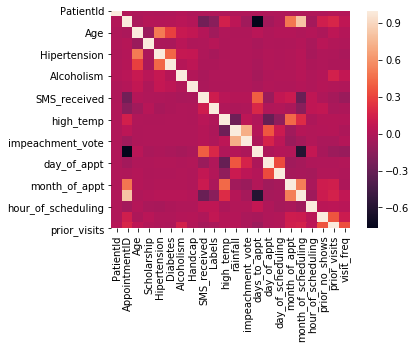

In [50]:
#Heatmap
ax = sns.heatmap(corr,  square=True)

In [0]:
# keep only desired features and labels
data_clean = data[['Labels','Gender','Age','SMS_received','day_of_appt','day_of_scheduling','month_of_appt','month_of_scheduling','hour_of_scheduling','days_to_appt','prior_no_shows','prior_visits',
                   'high_temp','rainfall','visit_freq','Scholarship']]


## 5. Preparing for Modelling

The cleaned data is divided into train/test sets (70/30) ratio below. OneHotEncoder() is used to encode categorical features and StandardScaler() is used to transform numerical features.  

In [52]:
data_clean.columns

Index(['Labels', 'Gender', 'Age', 'SMS_received', 'day_of_appt',
       'day_of_scheduling', 'month_of_appt', 'month_of_scheduling',
       'hour_of_scheduling', 'days_to_appt', 'prior_no_shows', 'prior_visits',
       'high_temp', 'rainfall', 'visit_freq', 'Scholarship'],
      dtype='object')

In [53]:
# split into test/train
train_set,test_set = train_test_split(data_clean,test_size=0.3,stratify=data_clean["Labels"])
print(len(train_set), "train +", len(test_set), "test")

# divide into features/labels
train_features = train_set.drop('Labels',axis=1)
train_labels = train_set[['Labels']]
test_features = test_set.drop('Labels',axis=1)
test_labels = test_set[['Labels']]

77368 train + 33159 test


In [0]:
# transform numerical and categorical features using StandardScaler() and OneHotEncoder()
num_attribs = ['Age','days_to_appt','prior_no_shows','high_temp','rainfall','prior_visits','visit_freq']
cat_attribs_one_hot = ['Gender','day_of_appt','day_of_scheduling','month_of_appt','month_of_scheduling','hour_of_scheduling']

pipeline_features = ColumnTransformer(
    [("num",StandardScaler(),num_attribs),("cat",OneHotEncoder(categories='auto',handle_unknown='ignore'),cat_attribs_one_hot)],remainder='passthrough')

train_features_prepared = pipeline_features.fit_transform(train_features)
train_labels_prepared = train_labels.values

test_features_prepared = pipeline_features.transform(test_features)
test_labels_prepared = test_labels.values

In [55]:
train_features_prepared.shape

(77368, 50)

In [56]:
test_features_prepared.shape

(33159, 50)